## Sanity Checks

This is a little notebook with some sanity checks.
Proper tests are in [tests/](./tests/).
This notebook is just to visually look at how the simulation behaves.
Note, there might be some extra libraries used here, which are not mentioned anywhere else.

In [1]:
from itertools import product
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from magicsoup.examples.wood_ljungdahl import MOLECULES, REACTIONS

theme_set(theme_minimal())
CHEMISTRY = ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS)

### Genome Sizes

I would expect overall more coding regions (CDSs) and thus more proteins in larger genomes.
However, the likelihood of encountering a stop codon (in-frame) should stay the same.
So, the average CDS length and thus the expected number of domains per protein should not grow with larger genomes.

In [2]:
genetics = ms.Genetics(chemistry=CHEMISTRY)
records = []
for size in (100, 200, 300, 400, 500, 1000):
    for _ in range(1000):
        genome = ms.random_genome(s=size)
        proteins = genetics.get_proteome(seq=genome)
        records.append({
            "size": size,
            "n": len(proteins),
            "v": "proteins/genome"
        })
        if len(proteins) > 0:
            records.append({
                "size": size,
                "n": sum(len(d.domains) for d in proteins) / len(proteins),
                "v": "domains/protein"
            })
df = pd.DataFrame.from_records(records)

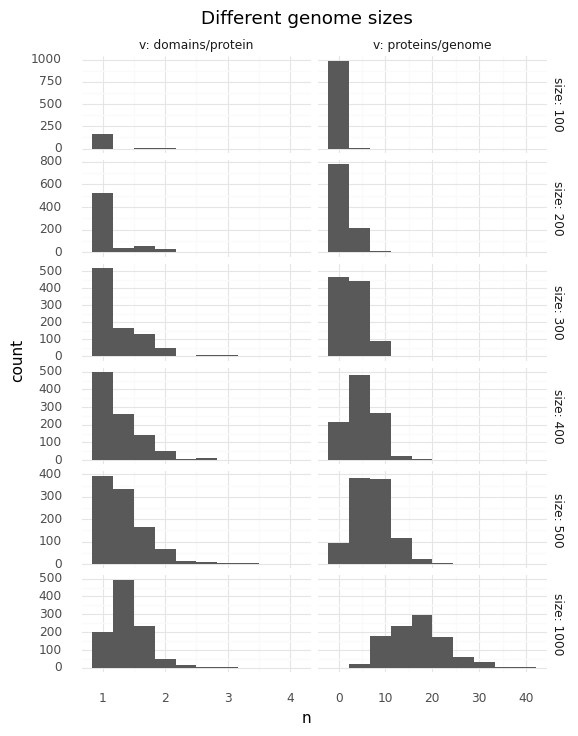

<ggplot: (8744086899965)>

In [3]:
(ggplot(df)
    + geom_histogram(aes(x="n"), bins=10)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(6, 8))
    + ggtitle("Different genome sizes"))

### Molecule Diffusion and Degradation

Below, I just want to see on a small map whether diffusion and degradation looks correct (_e.g._ using the circular map).
The diffusion coefficients and half lifes are what I would expect to be realistic values.
It would also be nice to see that differences in diffusion with different diffusion coefficients, and differences in degradation with different half lifes
actually make a visible difference.

In [4]:
ma = ms.Molecule("A", 10, diff_coef=1e-6, half_life=100_000)
mb = ms.Molecule("B", 10, diff_coef=1e-7, half_life=10_000)
mc = ms.Molecule("C", 10, diff_coef=1e-8, half_life=1_000)
molecules = [ma, mb, mc]

chemistry = ms.Chemistry(molecules=molecules, reactions=[])
world = ms.World(chemistry=chemistry, map_size=9, mol_map_init="zeros")
world.molecule_map[:, 4, 4] = 10.0
world.molecule_map[:, 5, 5] = 10.0
world.molecule_map[:, 8, 8] = 10.0

records = []
for si in range(10):
    for mi, mol in enumerate(molecules):
        for x, y in product(range(9), range(9)):
            records.append({
                "step": si,
                "mol": mol.name,
                "x": x,
                "y": y,
                "c": world.molecule_map[mi, x, y].item()
            })
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)

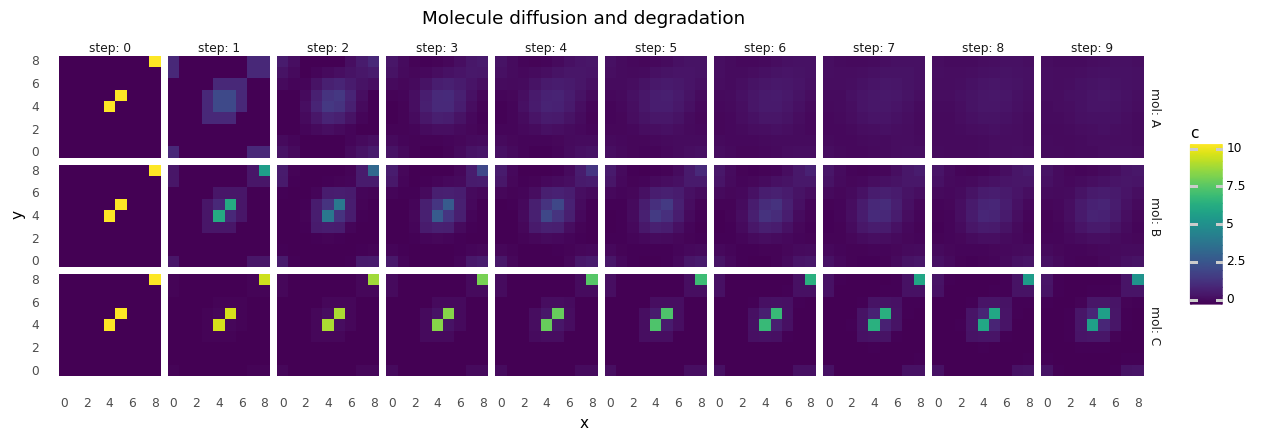

<ggplot: (8744086936751)>

In [5]:
(ggplot(df)
    + geom_tile(aes(x="x", y="y", fill="c"))
    + facet_grid("mol ~ step", labeller="label_both")
    + coord_equal(expand=False)
    + theme(figure_size=(14, 6))
    + ggtitle("Molecule diffusion and degradation"))

## Equilibrium Constants

Any reaction always moved into the direction of lowering Gibb's free energy $\Delta G = \Delta G_0 + RT \ln Q$.
This term is influenced by the internal energy difference of the reaction's substrates and products $\Delta G_0$, and by the change in entropy which can be expressed as a function of the reaction quotient $R \ln Q$.
At equilibrium these 2 terms cancel each other out $\Delta G_0 = RT \ln K_e$.
Thus, looking at the equilibrium constants $K_e$ of this simulation is good to see how favourable certain reactions are, or how much concentration gradients will influence the reaction.

For reactions such as $NADPH \rightleftharpoons NADP^- + H^+$ I expect large $K_e$s. However, the majority of $K_e$s should not be too far away from 1.0.
Otherwise, cells could not make any use of concentration gradients to gain energy.
Below, I look at each defined reaction separately.
Then, I am also looking at what reactions are catalyzed by proteins from random genomes.
These reaction however also include transporters, which always have $K_e = 1.0$.

In [6]:
world = ms.World(chemistry=CHEMISTRY)

records = []
for subs, prods in REACTIONS:
    name = " + ".join(str(d) for d in subs) + " <-> " + " + ".join(str(d) for d in prods)
    energy = sum(d.energy for d in prods) - sum(d.energy for d in subs)
    ke = Q = math.exp(-energy / (GAS_CONSTANT * world.abs_temp))
    records.append({"name": name, "Ke": ke})

genomes = [ms.random_genome(s=300) for _ in range(100)]
world.add_random_cells(genomes=genomes)
Ke = torch.exp(-world.kinetics.E / world.kinetics.abs_temp / GAS_CONSTANT)
for ke in Ke.flatten().tolist():
    records.append({"name": "random proteins", "Ke": ke})

df = pd.DataFrame.from_records(records)

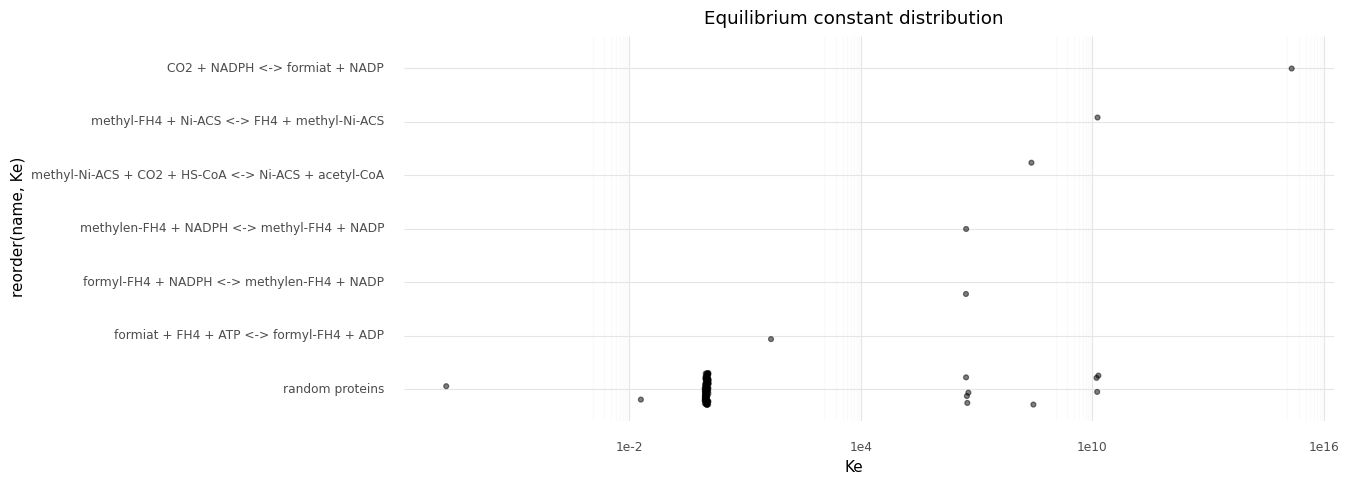

<ggplot: (8744086570518)>

In [15]:
(ggplot(df, aes(x="reorder(name, Ke)", y="Ke"))
    + geom_jitter(data=df, alpha=0.5, width=0.3, height=0.05)
    + scale_y_log10()
    + coord_flip()
    + theme(figure_size=(12, 5))
    + ggtitle("Equilibrium constant distribution"))

### Working Cell

Below I want to see how a cell actually starts to work and change its environment.
I currently don't have a clever way of defining a cell other than just assigning a genome.
So, the resulting cell is completely random.

First, a plot showing how the cell changes its environment over time.
Molecules suffixed with `[i]` are the intracellular molecule species, ones suffixed with `[e]` are the extracellular one
(on the pixel the cell lives on).

Second, networks depicting this cell's proteome.
To reduce the clutter I am plotting each protein one by one as a single network, instead of showing all proteins as a single network.
The protein itself is always the gray middle node with its size being proportional to $V_{Max}$.
Arrows point to and from substrates/products and effectors.
Substrates and product arrows are gray, inhibiting effectors are red, activating effectors are green.
Arrow widths are proportional to $K_M^{-1}$.
Intracellular molecules are blue, extracellular ones orange.

In [14]:
world = ms.World(chemistry=CHEMISTRY)
world.molecule_map *= 100
world.add_random_cells(genomes=[ms.random_genome(s=300)])
cell = world.cells[0]

records = []
for si in range(40):
    for mol in MOLECULES:
        records.append({
            "step": si,
            "molecule": f"{mol.name}[i]",
            "c": world.cell_molecules[0, mol.idx].item()
        })
        records.append({
            "step": si,
            "molecule": f"{mol.name}[e]",
            "c": world.molecule_map[mol.idx, cell.position[0], cell.position[1]].item()
        })
    world.enzymatic_activity()
    world.degrade_molecules()
    world.diffuse_molecules()
df = pd.DataFrame.from_records(records)

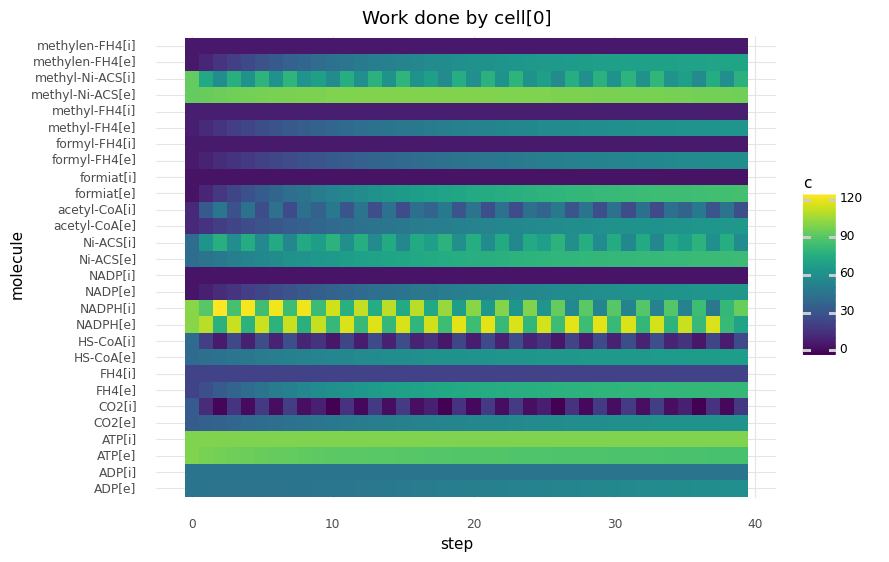

<ggplot: (8765849207287)>

In [15]:
(ggplot(df)
    + geom_tile(aes(x="step", y="molecule", fill="c"))
    + theme(figure_size=(8, 6))
    + ggtitle(f"Work done by cell[{cell.idx}]"))

In [16]:
graphs = []
for pi, protein in enumerate(cell.proteome):
    vs = []
    G = nx.DiGraph()
    for dom in protein.domains:
        kwargs = {
            "w": abs(1 / dom.affinity),
            "c": "gray"
        }
        if dom.is_catalytic:
            vs.append(dom.velocity)
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            for mol in dom.substrates:
                G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
            for mol in dom.products:
                G.add_edge("", f"{mol.name}{suffix}", **kwargs)
        if dom.is_transporter:
            vs.append(dom.velocity)
            mol = dom.substrates[0]
            G.add_edge(f"{mol.name}[i]", "", **kwargs)
            G.add_edge("", f"{mol.name}[e]", **kwargs)
        if dom.is_regulatory:
            kwargs["c"] = "r" if dom.is_inhibiting else "g"
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
    
    for key, val in G.nodes.items():
        if key == "":
            val["s"] = sum(vs) / len(vs) if len(vs) > 0 else 1.0
            val["c"] = "gray"
        else:
            val["s"] = 1.0
            val["c"] = "orange" if key.endswith("[e]") else "blue"

    graphs.append(G)

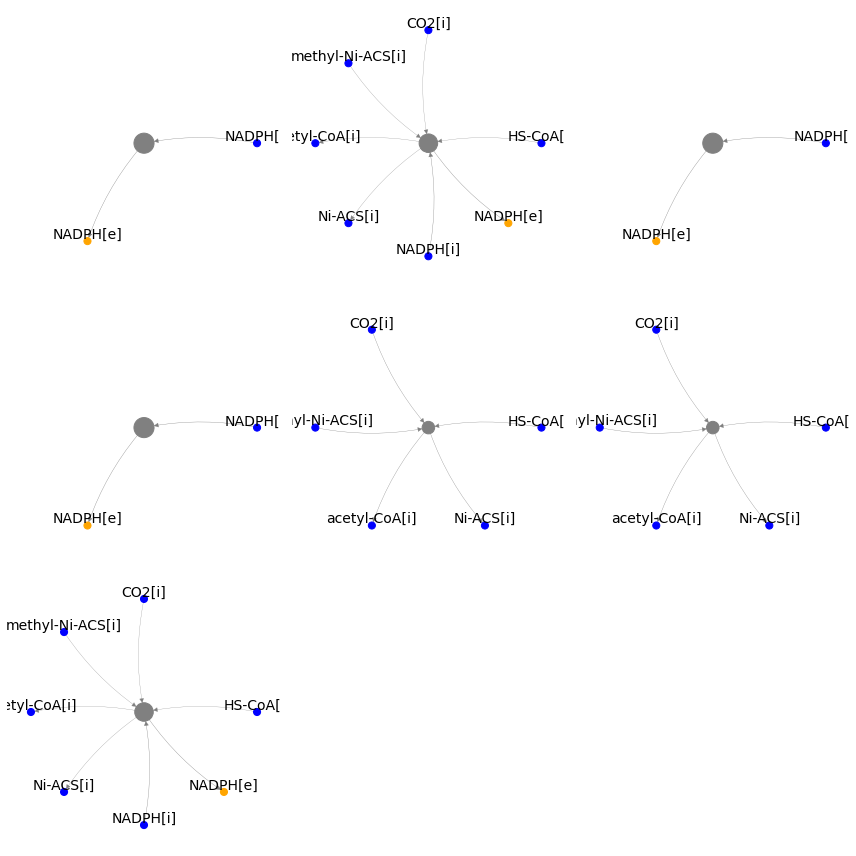

In [17]:
n_cols = 3
n_rows = int(math.ceil(len(graphs) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(n_cols * 4, n_rows * 4))

for plot_i, ax in enumerate(axs.flat):
    ax.axis("off")
    
    if plot_i < len(graphs):
        G = graphs[plot_i]
    
        pos = nx.circular_layout(G, center=(0, 0))
        pos[""] = (0, 0)
        
        edgewidths = [G.get_edge_data(u, v)["w"] for u, v in G.edges()]
        nodesizes = [v["s"] * 50 for v in G.nodes.values()]
        edgecols = [G.get_edge_data(u, v)["c"] for u, v in G.edges()]
        nodecols = [v["c"] for v in G.nodes.values()]

        nx.draw(
            G, pos, ax=ax,
            node_size=nodesizes,
            node_color=nodecols,
            width=edgewidths,
            edge_color=edgecols,
            connectionstyle="arc3,rad=0.1",
            
        )

        nx.draw_networkx_labels(G, pos, ax=ax, font_size=14, verticalalignment="bottom")
        ax.margins(0.1, 0.05)

fig.tight_layout()
plt.show()

In [219]:
world = ms.World(chemistry=CHEMISTRY)
world.molecule_map *= 100
world.add_random_cells(genomes=[ms.random_genome(s=300) for _ in range(1000)])

def entropy(t: torch.Tensor):
    p = t.flatten() / t.sum()
    return -torch.sum(p[p > 0.0] * torch.log(p[p > 0.0])).item() * GAS_CONSTANT

def energy(t: torch.Tensor):
    return sum(t[d.idx].sum().item() * d.energy for d in MOLECULES)

records = []
for step_i in range(250):
    if step_i >= 100:
        world.enzymatic_activity()
    if step_i >= 200:
        world.degrade_molecules()
    world.diffuse_molecules()
    U = energy(world.molecule_map) + energy(world.cell_molecules.T)
    S = entropy(world.molecule_map) + entropy(world.cell_molecules)
    records.append({
        "step": step_i,
        "U": U,
        "S": S,
        "G": U - world.abs_temp * S
    })

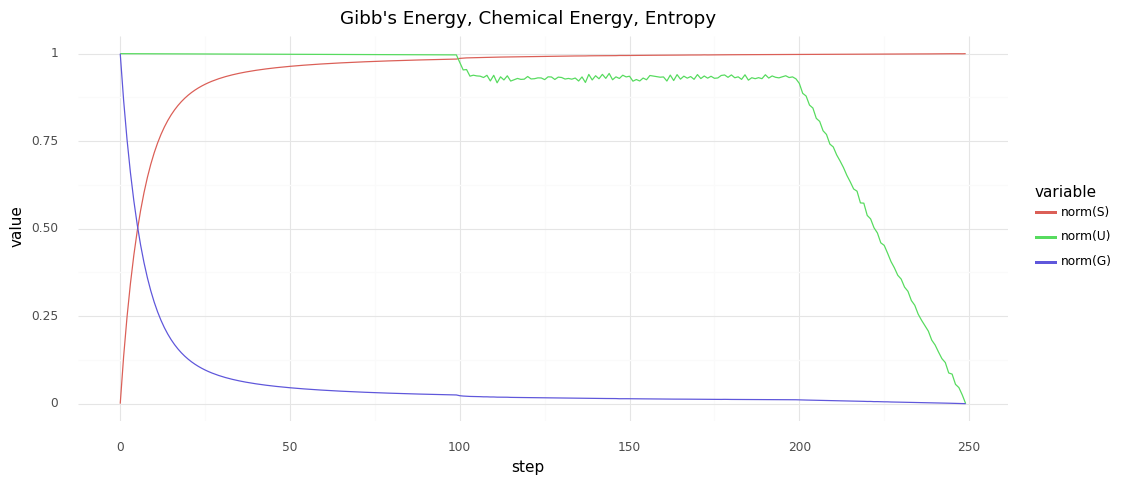

<ggplot: (8765841159720)>

In [199]:
df = pd.DataFrame.from_records(records)
df["norm(S)"] = (df["S"] - df["S"].min()) / (df["S"].max() - df["S"].min())
df["norm(U)"] = (df["U"] - df["U"].min()) / (df["U"].max() - df["U"].min())
df["norm(G)"] = (df["G"] - df["G"].min()) / (df["G"].max() - df["G"].min())
df = df.melt(id_vars=["step"], value_vars=["norm(G)", "norm(U)", "norm(S)"])
df["variable"] = pd.Categorical(df["variable"], categories=["norm(S)", "norm(U)", "norm(G)"])

(ggplot(df)
    + geom_line(aes(x="step", y="value", color="variable"))
    + theme(figure_size=(12, 5))
    #+ facet_grid("variable ~ .", scales="free_y")
    + ggtitle("Gibb's Energy, Internal Energy, Entropy"))

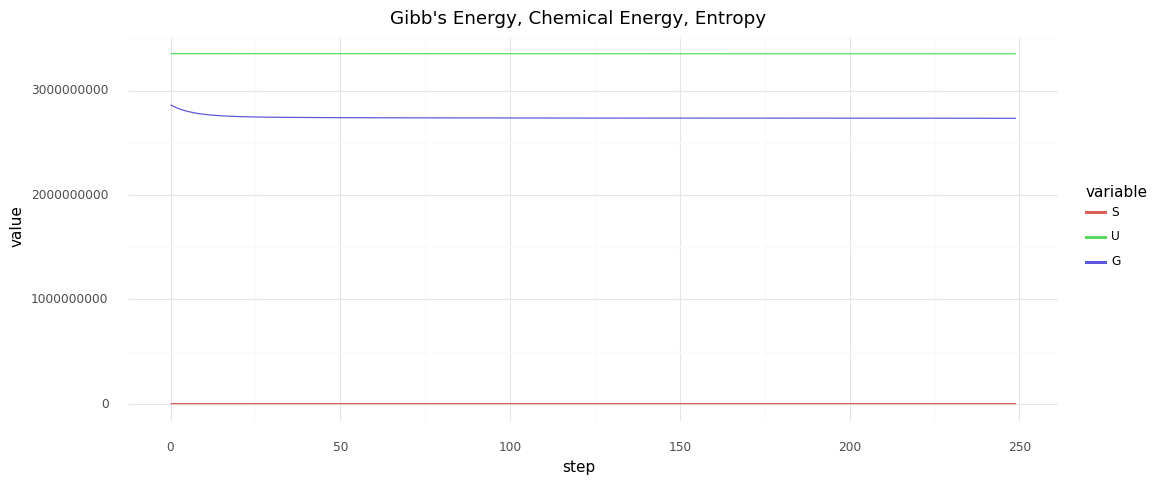

<ggplot: (8765823497930)>

In [198]:
df = pd.DataFrame.from_records(records)
df = df.melt(id_vars=["step"], value_vars=["G", "U", "S"])
df["variable"] = pd.Categorical(df["variable"], categories=["S", "U", "G"])

(ggplot(df)
    + geom_line(aes(x="step", y="value", color="variable"))
    + theme(figure_size=(12, 5))
    + ggtitle("Gibb's Energy, Chemical Energy, Entropy"))

In [217]:
# R * T * ln(Q) = -E
# Q = exp(-E / (R * T))
torch.exp(torch.tensor([-1000 / GAS_CONSTANT / world.abs_temp])).item()
1000 + world.abs_temp * GAS_CONSTANT * torch.log(torch.tensor([0.95])).item()

867.7923545216723

In [221]:
print(entropy(torch.tensor([0.0, 0.0, 5.0, 0.0, 0.0])))
print(entropy(torch.tensor([0.0, 1.5, 2.0, 1.5, 0.0])))
print(entropy(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0])))

-0.0
9.053619087088556
13.38161160919431
